In [1]:
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import LightningModule, Trainer
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from torch import optim
from tqdm import tqdm
import torch.nn.functional as F
import numpy as np
import torch
import math
import timm

import transforms.eft as Eft
from datasets.transformed_dataset import TransformedDataset
from utils import plot_confusion_matrix
from models.radio_rec_model import RadioRecNetwork
from models.resnet import create_resnet_2d
import datasets.signal_file_dataset as sfds

In [2]:
import pytorch_lightning as pl
pl.__version__

'1.6.0'

In [3]:
torch.__version__

'1.8.1'

In [4]:
print(torch.cuda.is_available())

True


In [5]:
root = "/home/zwlin/data/radiorec/64K"
sig_file_set = sfds.SignalFileSet(root, 'bin')
sig_file_set.print_info()

data path: /home/zwlin/data/radiorec/64K
classes: ['class1', 'class2', 'class3']
class dict: {'class1': 0, 'class2': 1, 'class3': 2}
{'class1': 1, 'class2': 1, 'class3': 1}


In [6]:
import datasets.signal_file_dataset as sfds
sig_file_conf = sfds.SignalFileConfig()
sig_file_conf.fs = 64000      # 64K Hz sample rate
sig_file_conf.seg_len = 500   # 500ms ???
sig_file_conf.seg_shift = 500 # 500 ms, no overlap
sig_file_conf.max_num = 2000
sig_file_conf.is_complex = True
sig_file_conf.energy_threshold = 1.0

sig_dataset = sfds.SignalDataSet(sig_file_set, sig_file_conf)
sig_dataset.print_info()

class list: ['class1', 'class2', 'class3']
class dict: {'class1': 0, 'class2': 1, 'class3': 2}
seg count for each class: {'class1': 1983, 'class2': 1979, 'class3': 1984}


In [7]:
sig_dataset.save('/home/zwlin/data/radiorec/64k.hdf5')

In [8]:
sig_dataset = sfds.SignalDataSet()
sig_dataset.load('/home/zwlin/data/radiorec/64k.hdf5')
sig_dataset.print_info()

class list: ['class1', 'class2', 'class3']
class dict: {'class1': 0, 'class2': 1, 'class3': 2}
seg count for each class: {'class1': 1983, 'class2': 1979, 'class3': 1984}


In [9]:
sig_dataset.data.shape

(5946, 32000, 2)

In [10]:
sig_dataset.labels.shape

(5946,)

In [11]:
class_list = sig_dataset.class_list
num_classes = len(class_list)

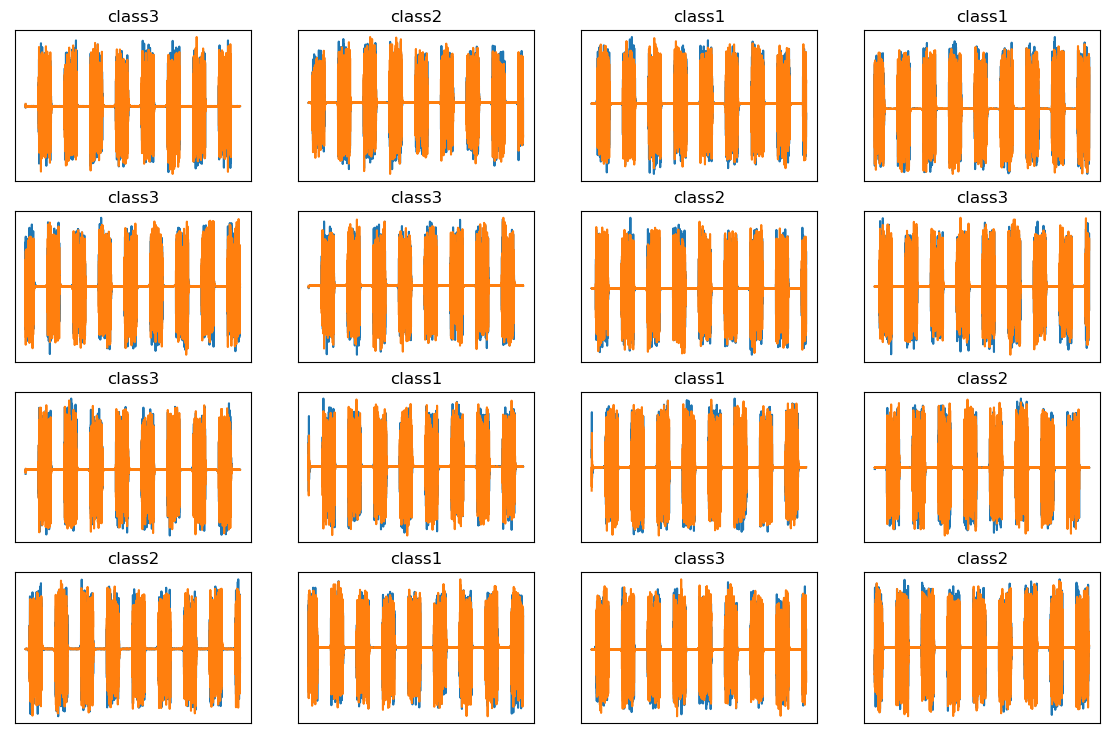

In [12]:
# Repeat but plot andom sampling of the data
from datasets.visualize import IQVisualizer

example_dataloader = DataLoader(
    dataset=sig_dataset,
    batch_size=16,
    num_workers=10,
    shuffle=True,
    drop_last=True,
)
visualizer = IQVisualizer(
    data_loader = example_dataloader,
    visualize_target_transform = lambda target: [class_list[int(index)] for index in target]
)

for figure in iter(visualizer):
    figure.set_size_inches(14, 9)
    plt.show()
    break

In [13]:
from transforms.transforms import Compose
from transforms.spectrogram_transform import SpectrogramConfig, Spectrogram

interleave_to_complex = Eft.InterleaveComplex()

spectrogram_config = SpectrogramConfig()
spectrogram_config.nperseg = 256
spectrogram_config.noverlap = 128
spectrogram_config.nfft = 256
spectrogram_config.window = 'hann'
spectrogram_config.return_onesided = False
spectrogram_config.mode = 'magnitude'

spectorgram_transform = Spectrogram(spectrogram_config)

ds = TransformedDataset(sig_dataset, transform = Compose([interleave_to_complex, spectorgram_transform]))

In [14]:
num_total = len(ds)
num_train = math.floor(0.8 * num_total)
num_val = math.floor(0.1 * num_total)
num_test = num_total - num_train - num_val

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(ds, [num_train, num_val, num_test],
                                                                         generator = torch.Generator().manual_seed(42))
idx = np.random.randint(len(train_dataset))
data, label = train_dataset[idx]
channels = data.shape[0]
print("Dataset length: {}".format(len(ds)))
print("Data shape: {}".format(data.shape))
print(f"Channels: {channels}")
print("Label Index: {}".format(label))
print("Label Class: {}".format(class_list[label]))

Dataset length: 5946
Data shape: (1, 256, 249)
Channels: 1
Label Index: 1
Label Class: class2


In [15]:
# ----
# ### Format Dataset for Training
# Next, the datasets are then wrapped as `DataLoaders` to prepare for training.

# Create dataloaders
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=16,
    num_workers=8,
    shuffle=True,
    drop_last=True,
)
val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=16,
    num_workers=8,
    shuffle=False,
    drop_last=False,
)
test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=16,
    num_workers=8,
    shuffle=False,
    drop_last=False,
)

In [16]:
model = create_resnet_2d(name = 'resnet18', pretrained = False, num_classes = num_classes, in_chans = channels)
model

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [18]:
# Training Config
learning_rate=0.002
epochs = 50

radiorec_model = RadioRecNetwork(model, learning_rate = learning_rate)

In [19]:
# ----
# ### Train the Model
# To train the model, we first create a `ModelCheckpoint` to monitor the validation loss over time and save the best model as we go. The network is then instantiated and passed into a `Trainer` to kick off training.
import os
checkpoint_dir=f'exp/radiorec/duijiangji-checkpoints'
if not os.path.exists(checkpoint_dir):
    print(f'mkdir: {checkpoint_dir}')
    os.makedirs(checkpoint_dir)

mkdir: exp/radiorec/duijiangji-checkpoints


In [20]:
# Setup checkpoint callbacks
checkpoint_callback = ModelCheckpoint(
    dirpath=checkpoint_dir,
    filename='{epoch}-{val_loss:.2f}',
    save_top_k=3,
    save_last=True,
    verbose=True,
    monitor="val_loss",
    mode="min",
)

In [21]:
# Create and fit trainer

trainer = Trainer(
    max_epochs=epochs, callbacks=checkpoint_callback, devices=1, accelerator="gpu"
)

trainer.fit(radiorec_model, train_dataloaders=train_dataloader, val_dataloaders = val_dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type   | Params
--------------------------------
0 | mdl  | ResNet | 11.2 M
--------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.687    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 297: 'val_loss' reached 0.54234 (best 0.54234), saving model to '/home/zwlin/projects/radiorec/src/RadioRec/exp/radiorec/duijiangji-checkpoints/epoch=0-val_loss=0.54.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 594: 'val_loss' reached 1.59109 (best 0.54234), saving model to '/home/zwlin/projects/radiorec/src/RadioRec/exp/radiorec/duijiangji-checkpoints/epoch=1-val_loss=1.59.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 891: 'val_loss' reached 0.01429 (best 0.01429), saving model to '/home/zwlin/projects/radiorec/src/RadioRec/exp/radiorec/duijiangji-checkpoints/epoch=2-val_loss=0.01.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 1188: 'val_loss' reached 0.74885 (best 0.01429), saving model to '/home/zwlin/projects/radiorec/src/RadioRec/exp/radiorec/duijiangji-checkpoints/epoch=3-val_loss=0.75.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 1485: 'val_loss' reached 0.00628 (best 0.00628), saving model to '/home/zwlin/projects/radiorec/src/RadioRec/exp/radiorec/duijiangji-checkpoints/epoch=4-val_loss=0.01.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 1782: 'val_loss' reached 0.40944 (best 0.00628), saving model to '/home/zwlin/projects/radiorec/src/RadioRec/exp/radiorec/duijiangji-checkpoints/epoch=5-val_loss=0.41.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 2079: 'val_loss' reached 0.02997 (best 0.00628), saving model to '/home/zwlin/projects/radiorec/src/RadioRec/exp/radiorec/duijiangji-checkpoints/epoch=6-val_loss=0.03.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 2376: 'val_loss' reached 0.01047 (best 0.00628), saving model to '/home/zwlin/projects/radiorec/src/RadioRec/exp/radiorec/duijiangji-checkpoints/epoch=7-val_loss=0.01.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 2673: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 2970: 'val_loss' reached 0.00189 (best 0.00189), saving model to '/home/zwlin/projects/radiorec/src/RadioRec/exp/radiorec/duijiangji-checkpoints/epoch=9-val_loss=0.00.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 10, global step 3267: 'val_loss' reached 0.00131 (best 0.00131), saving model to '/home/zwlin/projects/radiorec/src/RadioRec/exp/radiorec/duijiangji-checkpoints/epoch=10-val_loss=0.00.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 11, global step 3564: 'val_loss' reached 0.00080 (best 0.00080), saving model to '/home/zwlin/projects/radiorec/src/RadioRec/exp/radiorec/duijiangji-checkpoints/epoch=11-val_loss=0.00.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 12, global step 3861: 'val_loss' reached 0.00102 (best 0.00080), saving model to '/home/zwlin/projects/radiorec/src/RadioRec/exp/radiorec/duijiangji-checkpoints/epoch=12-val_loss=0.00.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 13, global step 4158: 'val_loss' reached 0.00079 (best 0.00079), saving model to '/home/zwlin/projects/radiorec/src/RadioRec/exp/radiorec/duijiangji-checkpoints/epoch=13-val_loss=0.00.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 14, global step 4455: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 15, global step 4752: 'val_loss' reached 0.00021 (best 0.00021), saving model to '/home/zwlin/projects/radiorec/src/RadioRec/exp/radiorec/duijiangji-checkpoints/epoch=15-val_loss=0.00.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 16, global step 5049: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 17, global step 5346: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 18, global step 5643: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 19, global step 5940: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 20, global step 6237: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 21, global step 6534: 'val_loss' reached 0.00018 (best 0.00018), saving model to '/home/zwlin/projects/radiorec/src/RadioRec/exp/radiorec/duijiangji-checkpoints/epoch=21-val_loss=0.00.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 22, global step 6831: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 23, global step 7128: 'val_loss' reached 0.00056 (best 0.00018), saving model to '/home/zwlin/projects/radiorec/src/RadioRec/exp/radiorec/duijiangji-checkpoints/epoch=23-val_loss=0.00.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 24, global step 7425: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 25, global step 7722: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 26, global step 8019: 'val_loss' reached 0.00036 (best 0.00018), saving model to '/home/zwlin/projects/radiorec/src/RadioRec/exp/radiorec/duijiangji-checkpoints/epoch=26-val_loss=0.00.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 27, global step 8316: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 28, global step 8613: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 29, global step 8910: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 30, global step 9207: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 31, global step 9504: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 32, global step 9801: 'val_loss' reached 0.00034 (best 0.00018), saving model to '/home/zwlin/projects/radiorec/src/RadioRec/exp/radiorec/duijiangji-checkpoints/epoch=32-val_loss=0.00.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 33, global step 10098: 'val_loss' reached 0.00026 (best 0.00018), saving model to '/home/zwlin/projects/radiorec/src/RadioRec/exp/radiorec/duijiangji-checkpoints/epoch=33-val_loss=0.00.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 34, global step 10395: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 35, global step 10692: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 36, global step 10989: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 37, global step 11286: 'val_loss' reached 0.00025 (best 0.00018), saving model to '/home/zwlin/projects/radiorec/src/RadioRec/exp/radiorec/duijiangji-checkpoints/epoch=37-val_loss=0.00.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 38, global step 11583: 'val_loss' reached 0.00022 (best 0.00018), saving model to '/home/zwlin/projects/radiorec/src/RadioRec/exp/radiorec/duijiangji-checkpoints/epoch=38-val_loss=0.00.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 39, global step 11880: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 40, global step 12177: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 41, global step 12474: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 42, global step 12771: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 43, global step 13068: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 44, global step 13365: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 45, global step 13662: 'val_loss' reached 0.00020 (best 0.00018), saving model to '/home/zwlin/projects/radiorec/src/RadioRec/exp/radiorec/duijiangji-checkpoints/epoch=45-val_loss=0.00.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 46, global step 13959: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 47, global step 14256: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 48, global step 14553: 'val_loss' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 49, global step 14850: 'val_loss' was not in top 3


In [22]:
checkpoint_callback.best_model_path

'/home/zwlin/projects/radiorec/src/RadioRec/exp/radiorec/duijiangji-checkpoints/epoch=21-val_loss=0.00.ckpt'

In [24]:
# After the model is trained, the checkpoint's weights are loaded into the model and the model is put into evaluation mode. The validation set is looped through, inferring results for each example and saving the predictions and the labels. Finally, the labels and predictions are passed into our confusion matrix plotting function to view the results and also passed into the `sklearn.metrics.classification_report` method to print metrics of interest.
checkpoint_filename = checkpoint_callback.best_model_path
# checkpoint_filename = 'exp/radioml2018-iq-all-0.002-v3/checkpoints/epoch=26-val_loss=0.13.ckpt'

# Load best checkpoint
device = "cuda" if torch.cuda.is_available() else "cpu"
checkpoint = torch.load(
    checkpoint_filename, map_location=lambda storage, loc: storage
)

model = create_resnet_2d(name = 'resnet18', pretrained = False, num_classes = num_classes, in_chans = channels)
test_model = RadioRecNetwork(model, learning_rate = learning_rate)
test_model.load_state_dict(checkpoint["state_dict"])
test_model = test_model.to(device=device).eval()

In [25]:
# ### Evaluate the val set

# Infer results over validation set
num_val_examples = len(val_dataset)
y_raw_preds = np.empty((num_val_examples, num_classes))
y_preds = np.zeros((num_val_examples,))
y_true = np.zeros((num_val_examples,))

for i in tqdm(range(0, num_val_examples)):
    # Retrieve data
    idx = i  # Use index if evaluating over full dataset
    data, label = val_dataset[idx]
    # Infer
    data = torch.from_numpy(np.expand_dims(data, 0)).float().to(device)
    pred_tmp = test_model.predict(data)
    pred_tmp = pred_tmp.cpu().numpy() if torch.cuda.is_available() else pred_tmp
    # Argmax
    y_preds[i] = np.argmax(pred_tmp)
    # Store label
    y_true[i] = label

100%|████████████████████████████████████████| 594/594 [00:02<00:00, 266.34it/s]


Val set classification report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       184
         1.0       1.00      1.00      1.00       218
         2.0       1.00      1.00      1.00       192

    accuracy                           1.00       594
   macro avg       1.00      1.00      1.00       594
weighted avg       1.00      1.00      1.00       594



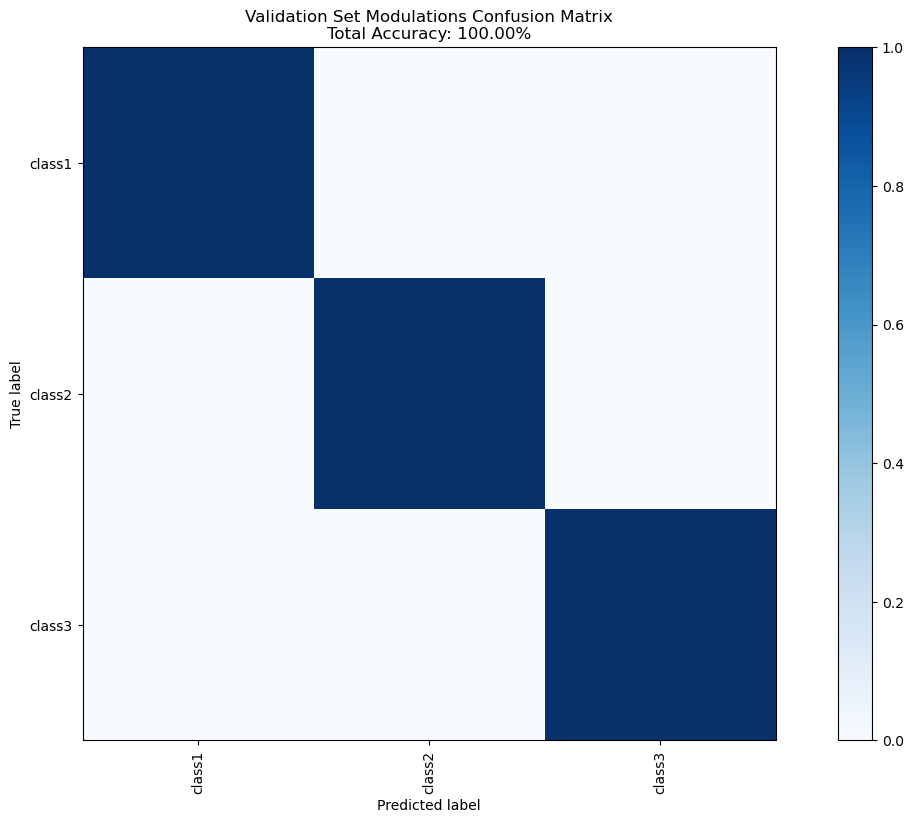

In [27]:
acc = np.sum(np.asarray(y_preds) == np.asarray(y_true)) / len(y_true)
plot_confusion_matrix(
    y_true,
    y_preds,
    classes = class_list,
    normalize = True,
    title="Validation Set Modulations Confusion Matrix\nTotal Accuracy: {:.2f}%".format(
        acc * 100
    ),
    text=False,
    rotate_x_text=90,
    figsize=(16, 9),
)
plt.savefig(f"{checkpoint_dir}/val_result.png")

print("Val set classification report:")
print(classification_report(y_true, y_preds))

100%|████████████████████████████████████████| 596/596 [00:02<00:00, 280.21it/s]


Test set classification report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       213
         1.0       1.00      1.00      1.00       203
         2.0       1.00      1.00      1.00       180

    accuracy                           1.00       596
   macro avg       1.00      1.00      1.00       596
weighted avg       1.00      1.00      1.00       596



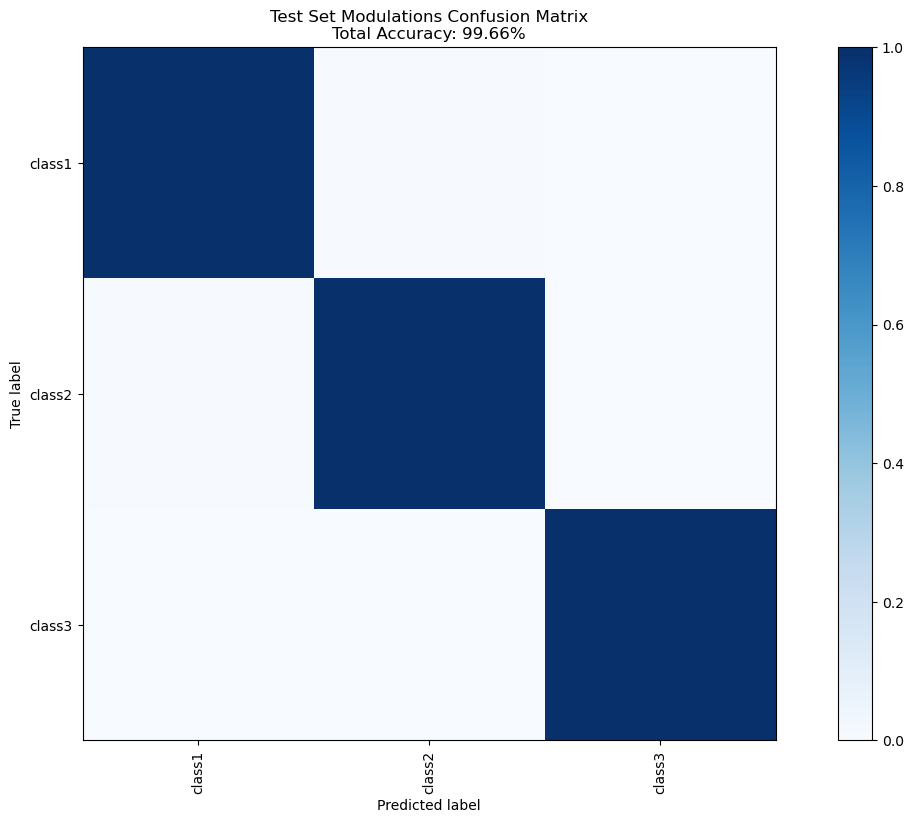

In [28]:
# ----
# ### Evaluate the test set

# Infer results over validation set
num_test_examples = len(test_dataset)
y_raw_preds = np.empty((num_test_examples, num_classes))
y_preds = np.zeros((num_test_examples,))
y_true = np.zeros((num_test_examples,))

for i in tqdm(range(0, num_test_examples)):
    # Retrieve data
    idx = i  # Use index if evaluating over full dataset
    data, label = test_dataset[idx]
    # Infer
    data = torch.from_numpy(np.expand_dims(data, 0)).float().to(device)
    pred_tmp = test_model.predict(data)
    pred_tmp = pred_tmp.cpu().numpy() if torch.cuda.is_available() else pred_tmp
    # Argmax
    y_preds[i] = np.argmax(pred_tmp)
    # Store label
    y_true[i] = label

acc = np.sum(np.asarray(y_preds) == np.asarray(y_true)) / len(y_true)
plot_confusion_matrix(
    y_true,
    y_preds,
    classes = class_list,
    normalize = True,
    title="Test Set Modulations Confusion Matrix\nTotal Accuracy: {:.2f}%".format(
        acc * 100
    ),
    text=False,
    rotate_x_text=90,
    figsize=(16, 9),
)
plt.savefig(f"{checkpoint_dir}/test_result.png")

print("Test set classification report:")
print(classification_report(y_true, y_preds))